In [1]:
import tensorflow as tf
import numpy as np
from tf_powersfa import *

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
n_out = 2

In [3]:
batch_size = 1000
N = 1000

encoding_x = tf.placeholder("float", [N,2])

Wx  = tf.Variable(tf.random_normal(stddev=0.1,shape=[2, n_out]))
b   = tf.Variable(tf.constant(0.1,shape=[n_out]))
dense0 = tf.matmul(encoding_x, Wx) + b
dense = alt_power_whitening(dense0, 2, 50)[0]


In [4]:

n_hidden = 20

x, y = tf.split(dense, 2, axis=1)
range_bs = list(range(N))
permuted_bs = list(np.random.permutation(range_bs))
sd_indices =  tf.constant([permuted_bs])
sd_indices   = tf.transpose(sd_indices)
shape        = tf.constant([batch_size,1])
y_    = tf.scatter_nd(sd_indices, y, tf.shape(y))

h_join = tf.concat([y, x], axis=1)
h_marg = tf.concat([y_, x], axis=1)

Wx1  = tf.Variable(tf.random_normal(stddev=0.1,shape=[2, n_hidden]))
b1   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx2  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b2   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx3  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b3   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx4  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b4   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx5  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, 1]))
b5   = tf.Variable(tf.constant(0.1,shape=[1]))

dense1_joint = tf.nn.leaky_relu(tf.matmul(h_join, Wx1) + b1)
dense2_joint = tf.nn.leaky_relu(tf.matmul(dense1_joint, Wx2) + b2)
dense3_joint = tf.nn.leaky_relu(tf.matmul(dense2_joint, Wx3) + b3)
dense4_joint = tf.nn.leaky_relu(tf.matmul(dense3_joint, Wx4) + b4)
dense5_joint = tf.matmul(dense4_joint, Wx5) + b5



dense1_marg = tf.nn.leaky_relu(tf.matmul(h_marg, Wx1) + b1)
dense2_marg = tf.nn.leaky_relu(tf.matmul(dense1_marg, Wx2) + b2)
dense3_marg = tf.nn.leaky_relu(tf.matmul(dense2_marg, Wx3) + b3)
dense4_marg = tf.nn.leaky_relu(tf.matmul(dense3_marg, Wx4) + b4)
dense5_marg = tf.matmul(dense4_marg, Wx5) + b5


loss = tf.reduce_mean(dense5_joint)-tf.log(tf.reduce_mean(tf.exp(dense5_marg)))
train_encoder     = tf.train.AdamOptimizer(0.005).minimize(loss, var_list=[Wx, b])
train_step = tf.contrib.opt.NadamOptimizer(0.002).minimize(-loss, var_list=[Wx1, b1, Wx2, b2, Wx3, b3, Wx4, b4, Wx5, b5]) #, var_list=[unmixing_W])


/home/hlynur/.local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 2
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


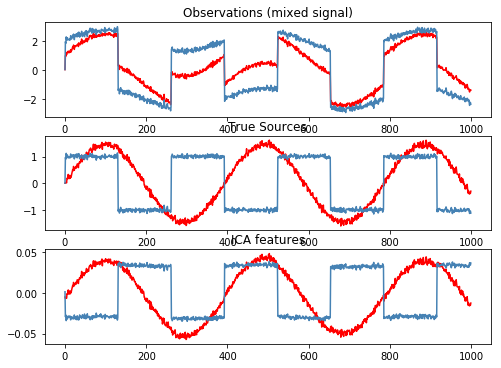

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

time = np.linspace(0, 8, batch_size)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
S = np.c_[s1, s2]
S += 0.05 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue']
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

In [6]:
shuffled_x = np.array(X)


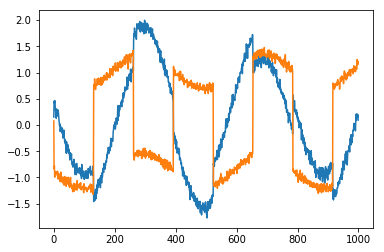

step: 0, loss: 6.324052810668945e-05
[[-0.05515789 -0.08152615]
 [-0.00395959 -0.01327964]]


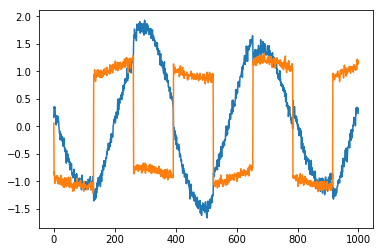

step: 50, loss: 0.02014559507369995
step: 100, loss: 0.20206522941589355
step: 150, loss: -0.17289388179779053
step: 200, loss: 0.31302356719970703
step: 250, loss: -0.1546630859375
step: 300, loss: 0.8104915618896484
step: 350, loss: 1.3612098693847656
step: 400, loss: -0.16109848022460938
[[0.11392501 0.25110063]
 [0.3086119  0.19266479]]


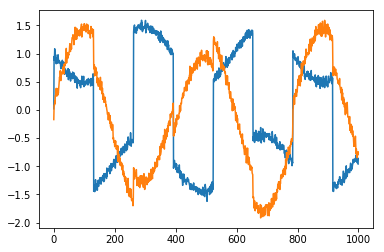

step: 450, loss: 1.1724319458007812
step: 500, loss: 0.910552978515625
step: 550, loss: 0.5758514404296875
step: 600, loss: 1.1172714233398438
step: 650, loss: -0.27734375
step: 700, loss: 0.7108078002929688
step: 750, loss: 0.46707916259765625
step: 800, loss: 0.70050048828125
[[-0.42898828  0.30619526]
 [-0.19736008  0.4890698 ]]


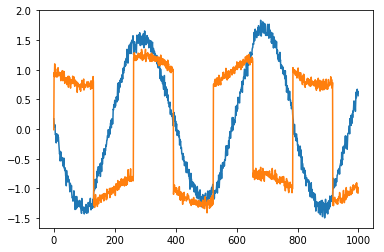

step: 850, loss: 0.011379241943359375
step: 900, loss: 0.5877227783203125
step: 950, loss: -0.11697769165039062
step: 1000, loss: 0.5765037536621094
step: 1050, loss: 0.16826629638671875
step: 1100, loss: 0.3267631530761719
step: 1150, loss: 0.1020050048828125
step: 1200, loss: 0.356231689453125
[[-0.48814064  0.36169657]
 [-0.21598242  0.5879272 ]]


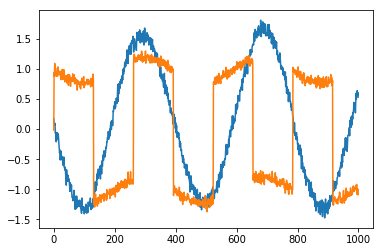

step: 1250, loss: 0.01404571533203125
step: 1300, loss: 0.3407936096191406
step: 1350, loss: -0.3295326232910156
step: 1400, loss: 0.4598731994628906
step: 1450, loss: -0.08240890502929688
step: 1500, loss: 0.2673835754394531
step: 1550, loss: 0.4466705322265625
step: 1600, loss: -0.22999191284179688
[[-0.52586967  0.4035546 ]
 [-0.22568204  0.66628593]]


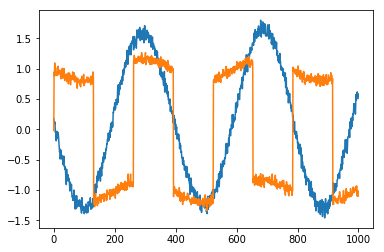

step: 1650, loss: 0.3719978332519531
step: 1700, loss: 0.2479095458984375
step: 1750, loss: -0.20737075805664062
step: 1800, loss: 0.5587959289550781
step: 1850, loss: 0.13077163696289062
step: 1900, loss: 0.16645050048828125
step: 1950, loss: 0.3005409240722656
step: 2000, loss: 0.11496734619140625
[[-0.5289933   0.47405827]
 [-0.20132884  0.7637115 ]]


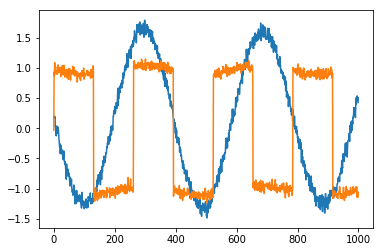

step: 2050, loss: -0.1455535888671875
step: 2100, loss: 0.28266143798828125


KeyboardInterrupt: 

In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    encoding = sess.run(dense, feed_dict={encoding_x:X})
    plt.plot(encoding)
    plt.show()
    for i in range(4001):
        np.random.shuffle(shuffled_x)
        current_loss, _ = sess.run([loss, train_step], feed_dict={encoding_x:X})
        if i % 2 is 0: current_loss, _ = sess.run([loss, train_encoder], feed_dict={encoding_x:X})
        if i % 50 is 0: print("step: {}, loss: {}".format(i, current_loss))         
        if i % 400 is 0:
            v = sess.run(Wx)
            print(v)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()